In [161]:
import keras
from keras import layers


In [162]:
import keras_tuner


In [163]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=[28, 28]))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=1),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [164]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="C:/Users/nisse/OneDrive - Högskolan Väst/IAI600/Lab 7",
    project_name="helloworld",
)

In [165]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [166]:
import keras
import numpy as np

(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x[:-10000]
x_val = x[-10000:]
y_train = y[:-10000]
y_val = y[-10000:]

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [167]:
import tensorflow

stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [168]:
tuner.search(x_train, y_train, epochs=50, batch_size=784, validation_data=(x_val, y_val), callbacks=[stop_early])

Trial 3 Complete [00h 01m 30s]
val_accuracy: 0.9584999978542328

Best val_accuracy So Far: 0.9828000068664551
Total elapsed time: 00h 04m 05s
INFO:tensorflow:Oracle triggered exit


In [169]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 507)               397995    
                                                                 
 dropout (Dropout)           (None, 507)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5080      
                                                                 
Total params: 403,075
Trainable params: 403,075
Non-trainable params: 0
_________________________________________________________________


In [170]:
tuner.results_summary()

Results summary
Results in C:/Users/nisse/OneDrive - Högskolan Väst/IAI600/Lab 7\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 507
activation: relu
dropout: True
lr: 0.0015315675711345933
Score: 0.9828000068664551

Trial 1 summary
Hyperparameters:
num_layers: 4
units_0: 283
activation: tanh
dropout: True
lr: 0.003921412901411757
units_1: 32
units_2: 32
units_3: 32
Score: 0.9759500026702881

Trial 2 summary
Hyperparameters:
num_layers: 1
units_0: 81
activation: tanh
dropout: False
lr: 0.00020193356985061988
units_1: 486
units_2: 366
units_3: 181
Score: 0.9584999978542328


In [171]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
model = tuner.hypermodel.build(best_hp)

{'num_layers': 1, 'units_0': 507, 'activation': 'relu', 'dropout': True, 'lr': 0.0015315675711345933}


In [172]:
x_allt = np.concatenate((x_train, x_val), axis=0)
y_allt = np.concatenate((y_train, y_val), axis=0)

In [173]:
lastmodel = model.fit(x_allt, y_allt, epochs=50, batch_size=784, callbacks=[stop_early])

Epoch 1/50
77/77 [==============================] - 4s 25ms/step - loss: 0.4488 - accuracy: 0.8689
Epoch 2/50
77/77 [==============================] - 2s 23ms/step - loss: 0.1930 - accuracy: 0.9445
Epoch 3/50
77/77 [==============================] - 2s 24ms/step - loss: 0.1398 - accuracy: 0.9603
Epoch 4/50
77/77 [==============================] - 2s 24ms/step - loss: 0.1093 - accuracy: 0.9681
Epoch 5/50
77/77 [==============================] - 2s 23ms/step - loss: 0.0878 - accuracy: 0.9748
Epoch 6/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0747 - accuracy: 0.9786
Epoch 7/50
77/77 [==============================] - 2s 26ms/step - loss: 0.0630 - accuracy: 0.9820
Epoch 8/50
77/77 [==============================] - 2s 29ms/step - loss: 0.0538 - accuracy: 0.9841
Epoch 9/50
77/77 [==============================] - 2s 27ms/step - loss: 0.0477 - accuracy: 0.9859
Epoch 10/50
77/77 [==============================] - 2s 31ms/step - loss: 0.0430 - accuracy: 0.9872
Epoch 11/

In [174]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0692 - accuracy: 0.9832
Test accuracy: 0.9832000136375427


In [175]:
lastmodel.params

{'verbose': 1, 'epochs': 50, 'steps': 77}

In [176]:
lastmodel.history.keys()

dict_keys(['loss', 'accuracy'])

(0.0, 1.0)

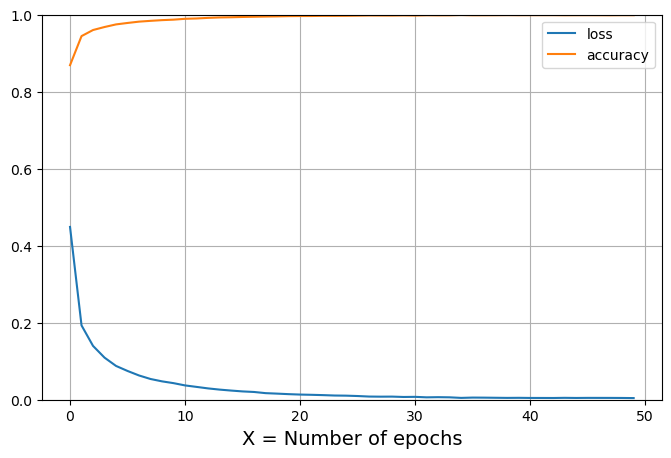

In [177]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.DataFrame(lastmodel.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel("X = Number of epochs", fontsize=14)
#plt.ylabel("Petal width", fontsize=14)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")


In [178]:
# https://www.tensorflow.org/tutorials/keras/keras_tuner
# https://keras.io/keras_tuner/getting_started/
# https://campus.datacamp.com/courses/introduction-to-deep-learning-with-keras/improving-your-model-performance?ex=9
# https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb